In [1]:
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import mplhep as hep
from coffea.util import load
import numpy as np
import pandas as pd
import awkward as ak
from coffea.nanoevents import NanoEventsFactory, NanoAODSchema
from numba import njit
import vector
import numba as nb
import numpy.ma as ma
vector.register_numba()
vector.register_awkward()
import matplotlib.pyplot as plt


from pprint import pprint 
hep.style.use(hep.style.ROOT)


import hist

In [2]:
df = ak.from_parquet("../dataset_1/all_jets_v6.parquet")

In [3]:
(jets,
partons_matched,
partons,
generator_info,
lepton_partons,
lepton_reco, 
met
) = ak.unzip(df)

jets = ak.with_name(jets, name="Momentum4D")
partons_matched = ak.with_name(partons_matched, name="Momentum4D")
partons = ak.with_name(partons, name="Momentum4D")
lepton_partons = ak.with_name(lepton_partons, name="Momentum4D")
lepton_reco = ak.with_name(lepton_reco, name="Momentum4D")
met = ak.with_name(met, name="Momentum4D")

jets.type

584143 * var * Momentum4D["pt": float32, "eta": float32, "phi": float32, "btag": float32, "m": float64, "matched": bool, "prov": float64]

In [7]:
def to_flat_numpy(X, fields, axis=1, allow_missing=False):
    return np.stack([ak.to_numpy(X[f], allow_missing=allow_missing) for f in fields], axis=axis)

def to_flat_tensor(X, fields, axis=1, allow_missing=False):
    return torch.tensor(np.stack([ak.to_numpy(X[f], allow_missing=allow_missing) for f in fields], axis=axis))

In [280]:
@njit
def sum_vectors_all(arrays):
    size = len(arrays)
    results = np.zeros((size, 4))
    for i, array in enumerate(arrays):
        total = vector.obj(px=0.0, py=0.0, pz=0.0, E=0.0)
        for v in array:
            total = total + v
        results[i, 0] = total.px
        results[i, 1] = total.py
        results[i, 2] = total.pz
        results[i, 3] = total.E
    return results

def get_vector_sum(vectors):
    out = sum_vectors_all(vectors)
    return vector.awk({
        "px": out[:, 0],
        "py": out[:, 1],
        "pz": out[:, 2],
        "E": out[:, 3],
    })

In [9]:
boost_jets = get_vector_sum(jets)
boost_reco = boost_jets + lepton_reco + met

jets_CM = jets.boost_beta3(-(boost_reco.to_beta3()))
lept_CM = lepton_reco.boost_beta3(-(boost_reco.to_beta3()))
met_CM = met.boost_beta3(-(boost_reco.to_beta3()))

CM_ALL = get_vector_sum(jets_CM) + lept_CM + met_CM
print(CM_ALL.px)
print(CM_ALL.py)

# PyTorch DNN dataset

In [410]:
import os
import os.path

import numpy as np
import torch
import awkward as ak
from tqdm import tqdm
from numba import njit

from torch.utils.data import Dataset

In [12]:
struct_jets = ak.zip({"pt": np.float32(0),
                "eta": np.float32(0),
                "phi": np.float32(0),
                "btag": np.float32(0),
                "m": np.float64(0),
                "matched": bool(0),
                "prov": 0.},
        with_name='Momentum4D')

ones_jets = ak.zip({"pt": np.float32(1),
                "eta": np.float32(1),
                "phi": np.float32(1),
                "btag": np.float32(1),
                "m": np.float64(1),
                "matched": bool(1),
                "prov": 1.},
        with_name='Momentum4D')

struct_lepton = ak.zip({"pt": np.float32(0),
                "eta": np.float32(0),
                "phi": np.float32(0),
                "m": np.float32(0)},
        with_name='Momentum4D')

ones_lepton = ak.zip({"pt": np.float32(1),
                "eta": np.float32(1),
                "phi": np.float32(1),
                "m": np.float32(1)},
        with_name='Momentum4D')

In [14]:
jets_CM_3 = jets.boost_p4(boost_reco.neg3D)

print(jets_CM_3.phi)

jets_CM_2 = jets.boost_beta3(-(boost_reco.to_beta3()))

print(jets_CM_2.phi)

jets_CM = jets.boostCM_of(boost_reco)

print(jets_CM.phi)

[[2.28, -0.438, -1.51, 0.571, 0.404], ... [-2.32, -1.61, 0.788, -0.448, 2.89]]
[[2.28, -0.438, -1.51, 0.571, 0.404], ... [-2.32, -1.61, 0.788, -0.448, 2.89]]
[[2.28, -0.438, -1.51, 0.571, 0.404], ... [-2.32, -1.61, 0.788, -0.448, 2.89]]


## TODO mask it's needed just for jets => delete for the others

In [411]:
class MyDataset(Dataset):
    def __init__(self, root, object_types=["jets", "lepton_reco", "met", "boost"], transform=None):

        self.fields = {
            "jets": ["pt", "eta", "phi", "btag","prov"],
            "lepton_reco" : ["pt", "eta", "phi", "m"],
            "met" : ["pt", "eta", "phi", "m"],
            "boost" : ["x", "y", "z", "t"]
        }
        
        self.root = root
        self.transform = transform
        self.object_types = object_types

        # if an object is missing (example: jets/lepton_reco/met/boost => compute boost)
        for object_type in self.object_types:
            if not os.path.isfile(self.processed_file_names(object_type)):
                print("File missing: compute boost")
                self.boost = self.get_boost()
                break
        
        for object_type in self.object_types:
            if not os.path.isfile(self.processed_file_names(object_type)):
                print("Create new file for " + object_type)
                self.process(object_type)
            else:
                print(object_type + " file already exists")
    
        self.mask_jets, self.data_jets = torch.load(self.processed_file_names("jets"))
        self.mask_lepton, self.data_lepton = torch.load(self.processed_file_names("lepton_reco"))
        self.mask_met, self.data_met = torch.load(self.processed_file_names("met"))
        self.mask_boost, self.data_boost = torch.load(self.processed_file_names("boost"))

        
    @property
    def raw_file_names(self):
        return [self.root + '/all_jets_v6.parquet']

    def processed_file_names(self, type):

        return (self.root + '/processed/' + type + '_data.pt')
        
    def get_boost(self):

        for file in self.raw_file_names:
            df = ak.from_parquet(file)

            jets = df["jets"]
            jets = ak.with_name(jets, name="Momentum4D")

            leptons = df["lepton_reco"]
            leptons = ak.with_name(leptons, name="Momentum4D")

            met = df["met"]
            met = ak.with_name(met, name="Momentum4D")
            
            boost_jets = get_vector_sum(jets)
            boost = boost_jets + leptons + met
        
        return boost_jets
        
    def boost_CM(self, objects_array, boost):
        objects_CM = objects_array.boost_p4(boost.neg3D)

        # Overwriting old pt by calling the function on the boosted object
        objects_CM["pt"] = objects_CM.pt
        objects_CM["eta"] = objects_CM.eta
        objects_CM["phi"] = objects_CM.phi

        return objects_CM
        
    def Reshape(self, input, value, ax):
        max_no = ak.max(ak.num(input, axis=ax))
        input_padded =  ak.pad_none(input, max_no, axis=ax)
        input_filled = ak.fill_none(input_padded, value, axis=ax)
    
        return input_filled
        
    # Get mask for object with pt = 0
    def get_mask_pt(self, objects_array):
        return objects_array[:,:,0] > 1e-5

    def process(self, object_type):
                
        for file in self.raw_file_names:
            df = ak.from_parquet(file)
            
            if (object_type == "boost"):
                objects = self.boost               

            else:
                objects = ak.with_name(df[object_type], name="Momentum4D")
                objects = self.boost_CM(objects, self.boost, object_type)

            if object_type == "jets":
                objects = self.Reshape(objects, struct_jets, 1)
                
            d_list = to_flat_numpy(objects, self.fields[object_type], axis=1, allow_missing=False)

            if object_type == "jets":
                d_list = np.transpose(d_list, (0, 2, 1))
                mask = self.get_mask_pt(d_list)

            if (object_type == "lepton_reco" or object_type == "met" or object_type == "boost"):
                d_list = np.expand_dims(d_list, axis=1)
                mask = np.ones((d_list.shape[0],d_list.shape[1]))

            tensor_data = torch.tensor(d_list, dtype = torch.float)
            tensor_mask = torch.tensor(mask, dtype = torch.float)

            torch.save((tensor_mask, tensor_data), self.processed_file_names(object_type))
                    
    def __getitem__(self, index):

        return (self.mask_lepton[index], self.data_lepton[index], self.mask_jets[index], 
                self.data_jets[index], self.mask_met[index], self.data_met[index], 
                self.mask_boost[index], self.data_boost[index])
            
    def __len__(self):
        size = len(self.mask_lepton)
        return size
        

In [412]:
data = MyDataset(".")

jets file already exists
lepton_reco file already exists
met file already exists
boost file already exists


In [354]:
from torch.utils.data import DataLoader

data_for_dataloader = MyDataset(".")
batch_size = parameters["batch_size"]

data_loaded = DataLoader(data_for_dataloader, batch_size=batch_size, shuffle=True, drop_last=True)
 
mask_lepton, data_lepton, mask_jets, data_jets, mask_met, data_met, mask_boost, data_boost = next(iter(data_loaded))

print(data_lepton.shape)

jets file already exists
lepton_reco file already exists
met file already exists
boost file already exists
torch.Size([64, 1, 4])


In [413]:
import torch
import torch.nn as nn

features_jets = data_jets.size(2)
features_rest = data_lepton.size(2)

lin_jet = nn.Linear(in_features=features_jets, 
         out_features=batch_size-1)

lin_lept = nn.Linear(in_features=features_rest, 
         out_features=batch_size-1)
lin_met = nn.Linear(in_features=features_rest, 
         out_features=batch_size-1)
lin_boost = nn.Linear(in_features=features_rest, 
         out_features=batch_size-1)

act_lin = nn.GELU()

jets_afterLin = act_lin(lin_jet(data_jets)*mask_jets[:,:,None])
lept_afterLin = act_lin(lin_lept(data_lepton))
met_afterLin = act_lin(lin_met(data_met))
boost_afterLin = act_lin(lin_boost(data_boost))

print(jets_afterLin.shape)
print(lept_afterLin.shape)

no_jets = data_jets.size(1)
no_lept = data_lepton.size(1)

ones = torch.ones(batch_size, no_jets, 1) # type jet = 1
two = 2*torch.ones(batch_size, no_lept, 1) # type lepton = 2
three = 3*torch.ones(batch_size, no_lept, 1) #type met = 3
four = 4*torch.ones(batch_size, no_lept, 1) #type boost = 4

# label each batch
jet_afterLin_andLabel = torch.cat((jets_afterLin, ones), dim=-1)
lept_afterLin_andLabel = torch.cat((lept_afterLin, two), dim=-1)
met_afterLin_andLabel = torch.cat((met_afterLin, three), dim=-1)
boost_afterLin_andLabel = torch.cat((boost_afterLin, four), dim=-1)

transformer_input = torch.concat((boost_afterLin_andLabel, lept_afterLin_andLabel, met_afterLin_andLabel, jet_afterLin_andLabel), dim=1)
transformer_mask = torch.concat((mask_boost, mask_lepton, mask_met, mask_jets), dim=1)

print(transformer_input.shape)
print(transformer_mask.shape)

torch.Size([64, 15, 63])
torch.Size([64, 1, 63])
torch.Size([64, 1, 63])
torch.Size([64, 1, 63])
torch.Size([64, 18, 64])
torch.Size([64, 18])


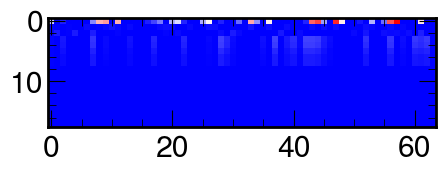

In [361]:
plt.figure(figsize=(5,3), dpi=100)
plt.imshow(transformer_input[0].detach().numpy(), cmap="bwr")

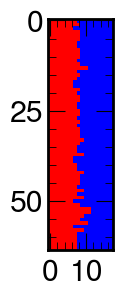

In [362]:
plt.figure(figsize=(5,3), dpi=100)
plt.imshow(transformer_mask.detach().numpy(), cmap="bwr")

In [395]:
## TRANSFORMER LAYER - mix information of objects (jets/boost/lepto_reco/met)

encoder_layer = nn.TransformerEncoderLayer(d_model=64,
                                           nhead=8,
                                          batch_first=True)

transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=2)

transformer_output = transformer_encoder(transformer_input, src_key_padding_mask=transformer_mask==0)

print(transformer_output.shape)
print(transformer_mask.shape)

torch.Size([64, 18, 64])
torch.Size([64, 18])


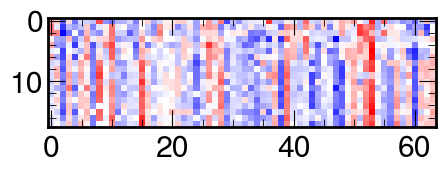

In [365]:
plt.figure(figsize=(5,3), dpi=100)
plt.imshow(transformer_output[2].detach().numpy(), cmap="bwr")

In [396]:
#avgpool_2d = nn.AvgPool2d(kernel_size=[no_jets,1], stride=[1,1], count_include_pad=True)
#jet_avg = avgpool_2d(jet_transformed)

transformer_output_sum = torch.sum(transformer_output*torch.unsqueeze(transformer_mask, -1), dim=1)
N_valid_objects = torch.sum(transformer_mask, dim=1)

conditional_input = transformer_output_sum / N_valid_objects

print(conditional_input[0])

tensor([-0.5750, -0.3065, -1.3320,  0.4767,  0.2328,  0.8502,  0.7590,  1.3590,
        -0.7430, -0.6594,  0.7448, -0.1145, -0.4491, -0.5248,  0.0850, -0.7571,
         0.1367,  0.6200, -1.3432, -0.1290,  1.7364, -0.8541,  1.0024,  0.3642,
         0.0263,  0.2796, -0.3123, -0.1361,  0.0645,  1.1189, -1.3998, -0.8275,
        -0.2589, -0.6850,  0.0866,  0.0945, -0.0717, -0.0387, -1.4693,  0.9252,
        -0.7666, -0.6904,  0.2970,  0.2043,  0.0895,  0.4353, -0.3228, -0.7584,
         0.3666,  0.4322,  0.6766, -0.1475,  0.5074, -0.8012,  0.2915,  0.3530,
        -1.1454,  0.4822,  0.3218,  1.0815,  0.7253,  0.7914,  0.6603, -0.1783],
       grad_fn=<SelectBackward0>)


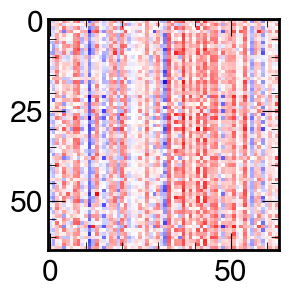

In [325]:
plt.figure(figsize=(5,3), dpi=100)
plt.imshow(conditional_input.detach().numpy(), cmap="bwr")

In [463]:
import torch
from torch.nn import Linear, Parameter


class ConditioningTransformerLayer():
    def __init__(self, jets_features, lepton_features, out_features, nhead, no_layers):
        super().__init__()
        
        self.lin_jet = nn.Linear(in_features=jets_features, 
                out_features=out_features-1)
        self.lin_lept = nn.Linear(in_features=lepton_features, 
                out_features=out_features-1)
        self.lin_met = nn.Linear(in_features=lepton_features, 
                out_features=out_features-1)
        self.lin_boost = nn.Linear(in_features=lepton_features, 
                out_features=out_features-1)

        self.gelu = nn.GELU()
        encoder_layer = nn.TransformerEncoderLayer(d_model=out_features,
                                           nhead=nhead,
                                          batch_first=True)

        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=no_layers)

    def reset_parameters(self):
        lin_jet.reset_parameters()
        lin_lept.reset_parameters()
        lin_met.reset_parameters()
        lin_boost.reset_parameters()

    def forward(self, batch_jet, batch_lepton, batch_met, batch_boost, mask_jets, mask_lepton, mask_met, mask_boost):
        
        jets_afterLin = self.gelu(self.lin_jet(batch_jet)*mask_jets[:,:,None])
        lept_afterLin = self.gelu(self.lin_lept(batch_lepton))
        met_afterLin = self.gelu(self.lin_met(batch_met))
        boost_afterLin = self.gelu(self.lin_boost(batch_boost))

        no_jets = batch_jet.size(1)
        no_lept = batch_lepton.size(1)

        ones = torch.ones(batch_size, no_jets, 1) # type jet = 1
        two = 2*torch.ones(batch_size, no_lept, 1) # type lepton = 2
        three = 3*torch.ones(batch_size, 1, 1) #type met = 3
        four = 4*torch.ones(batch_size, 1, 1) #type boost = 4

        jet_afterLin_andLabel = torch.cat((jets_afterLin, ones), dim=-1)
        lept_afterLin_andLabel = torch.cat((lept_afterLin, two), dim=-1)
        met_afterLin_andLabel = torch.cat((met_afterLin, three), dim=-1)
        boost_afterLin_andLabel = torch.cat((boost_afterLin, four), dim=-1)

        transformer_input = torch.concat((boost_afterLin_andLabel, lept_afterLin_andLabel, met_afterLin_andLabel, jet_afterLin_andLabel), dim=1)
        transformer_mask = torch.concat((mask_boost, mask_lepton, mask_met, mask_jets), dim=1)

        transformer_output = self.transformer_encoder(transformer_input, src_key_padding_mask=transformer_mask==0)

        # `computing ther average of not masked objects`
        transformer_output_sum = torch.sum(transformer_output*torch.unsqueeze(transformer_mask, -1), dim=1)
        N_valid_objects = torch.sum(transformer_mask, dim=1)

        conditional_input = transformer_output_sum / N_valid_objects

        return torch.cat((batch_boost[:,:,3:4].squeeze(1) , conditional_input), dim=1)




In [464]:
data_for_dataloader = MyDataset(".")
batch_size = parameters["batch_size"]

# Read Data
data_loaded = DataLoader(data_for_dataloader, batch_size=batch_size, shuffle=True, drop_last=True)
mask_lepton, data_lepton, mask_jets, data_jets, mask_met, data_met, mask_boost, data_boost = next(iter(data_loaded))

# Initialize Transformer Layer
transformer = ConditioningTransformerLayer(jets_features=data_jets.size(2), lepton_features=data_lepton.size(2), out_features=64, nhead=8, no_layers=2)

# Obtain conditional_input from transformer (pass batches and masks to `forward` method)
conditional_input = transformer.forward(data_jets, data_lepton, data_met, data_boost, mask_jets, mask_lepton, mask_met, mask_boost)

jets file already exists
lepton_reco file already exists
met file already exists
boost file already exists


In [458]:
data_boost.shape

torch.Size([64, 1, 4])

In [465]:
conditional_input

tensor([[ 6.8737e+02, -3.9325e-02, -9.7365e-01,  ...,  1.2121e-01,
         -1.7824e+00, -8.6738e-01],
        [ 1.3469e+03, -2.8815e-01, -1.4740e+00,  ...,  4.8400e-01,
         -2.4362e+00, -1.4099e+00],
        [ 4.1650e+02, -4.1738e-01, -3.1352e-01,  ..., -1.1846e-01,
         -5.9223e-01, -1.1242e+00],
        ...,
        [ 4.4878e+02, -2.1432e-01, -4.0481e-01,  ...,  1.8894e-01,
         -9.3480e-01, -1.5947e+00],
        [ 2.7949e+02,  2.7684e-01, -4.5928e-01,  ...,  1.1562e-01,
         -9.4615e-01, -1.2208e+00],
        [ 3.3001e+02,  8.5581e-02, -1.1587e+00,  ...,  3.8767e-01,
         -2.2009e+00, -1.2676e+00]], grad_fn=<CatBackward0>)

In [447]:
import torch
from torch.nn import Linear, Parameter


class Test():
    def __init__(self):
        super().__init__()

    # compute px and py(for every frame - should be equal to 0)
    # input = batches (jet, lepton, met)
    def check_px_py(self, batches):
        batch_jet = batches[0]
        batch_lepton = batches[1]
        batch_met = batches[2]

        jets_px = np.cos(batch_jet[:,:,2])*batch_jet[:,:,0]
        lept_px = np.cos(batch_lepton[:,:,2])*batch_lepton[:,:,0]
        met_px = np.cos(batch_met[:,:,2])*batch_met[:,:,0]

        jets_px_sum = torch.sum(jets_px, dim=1)
        jets_px_sum = torch.unsqueeze(jets_px_sum, 1)

        objects_px_per_event = torch.cat((jets_px_sum, lept_px, met_px), dim=1)
        sum_px_per_event = torch.sum(objects_px_per_event, dim=1)
        
        jets_py = np.sin(batch_jet[:,:,2])*batch_jet[:,:,0]
        lept_py = np.sin(batch_lepton[:,:,2])*batch_lepton[:,:,0]
        met_py = np.sin(batch_met[:,:,2])*batch_met[:,:,0]

        jets_py_sum = torch.sum(jets_py, dim=1)
        jets_py_sum = torch.unsqueeze(jets_py_sum, 1)

        objects_py_per_event = torch.cat((jets_py_sum, lept_py, met_py), dim=1)
        sum_py_per_event = torch.sum(objects_py_per_event, dim=1)

        return sum_px_per_event, sum_py_per_event
    
    # compute pz (for CM frame - should be equal to 0)
    # input = batches (jet, lepton, met)
    def check_pz(self, batches):
        batch_jet = batches[0]
        batch_lepton = batches[1]
        batch_met = batches[2]

        jets_pz = np.sinh(batch_jet[:,:,1])*batch_jet[:,:,0]
        lept_pz = np.sinh(batch_lepton[:,:,1])*batch_lepton[:,:,0]
        met_pz = np.sinh(batch_met[:,:,1])*batch_met[:,:,0]

        jets_pz_sum = torch.sum(jets_pz, dim=1)
        jets_pz_sum = torch.unsqueeze(jets_pz_sum, 1)

        objects_pz_per_event = torch.cat((jets_pz_sum, lept_pz, met_pz), dim=1)
        sum_pz_per_event = torch.sum(objects_pz_per_event, dim=1)

        return sum_pz_per_event


    

In [448]:
data_for_dataloader = MyDataset(".")
batch_size = parameters["batch_size"]

data_loaded = DataLoader(data_for_dataloader, batch_size=batch_size, shuffle=True, drop_last=True)

mask_lepton, data_lepton, mask_jets, data_jets, mask_met, data_met, mask_boost, data_boost = next(iter(data_loaded))

test = Test()

px, py = test.check_px_py((data_jets, data_lepton, data_met))
pz = test.check_pz((data_jets, data_lepton, data_met))

jets file already exists
lepton_reco file already exists
met file already exists
boost file already exists


In [437]:
jet_conv = nn.Conv1d(in_channels=15, out_channels=15, kernel_size=7, stride=1)